In [5]:
%matplotlib inline


In [6]:
# ================================
# FUZZY CONTROL SYSTEM:
# Student Performance Estimation
# ================================

import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load Dataset
# -------------------------------
df = pd.read_csv("fuzzy_students_120.csv")
print("Dataset loaded successfully!")
print(df.head())

Dataset loaded successfully!
   student_id  study_hours  sleep_hours  score
0           1         6.30         6.28   56.4
1           2         3.79         6.64   41.8
2           3         6.94         4.98   53.5
3           4         5.73         5.90   53.8
4           5         1.21         5.33   22.0


In [7]:
study = ctrl.Antecedent(np.arange(0, 8.5, 0.1), 'study')     # hours/day
sleep = ctrl.Antecedent(np.arange(4, 8.5, 0.1), 'sleep')     # hours/day
score = ctrl.Consequent(np.arange(20, 101, 1), 'score')      # exam score %

In [8]:
study['low'] = fuzz.trimf(study.universe, [0, 0, 3])
study['medium'] = fuzz.trimf(study.universe, [2.5, 4.5, 6.5])
study['high'] = fuzz.trimf(study.universe, [5.5, 8, 8])

sleep['short'] = fuzz.trimf(sleep.universe, [4, 4, 6])
sleep['ok'] = fuzz.trimf(sleep.universe, [5.5, 6.5, 7.5])
sleep['long'] = fuzz.trimf(sleep.universe, [7, 8, 8])

score['low'] = fuzz.trimf(score.universe, [20, 20, 55])
score['medium'] = fuzz.trimf(score.universe, [45, 65, 80])
score['high'] = fuzz.trimf(score.universe, [70, 100, 100])


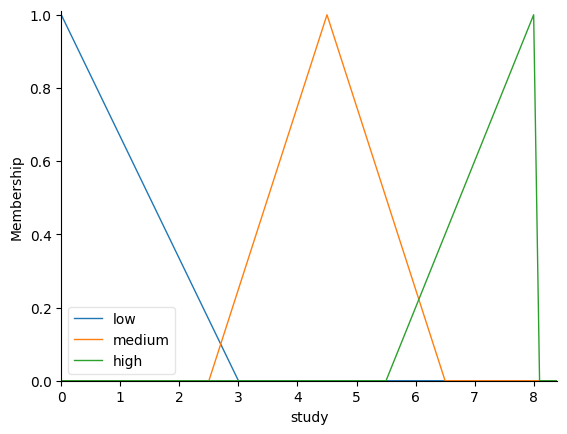

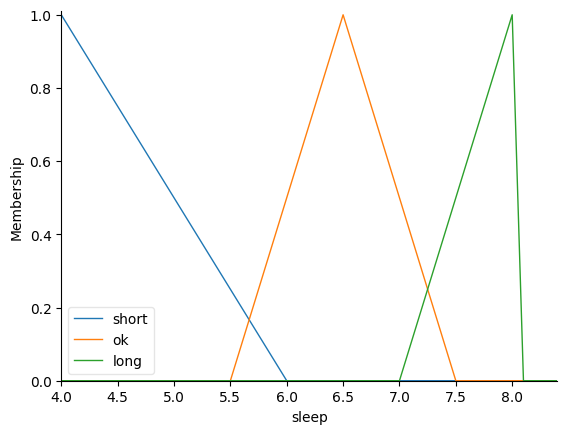

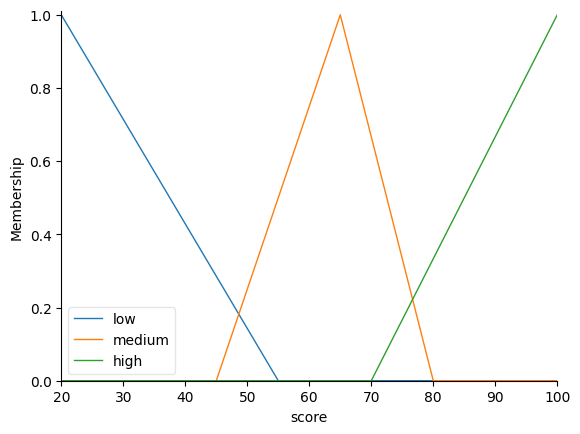

In [29]:
# -------------------------------
# 4. Visualize Membership Functions
# -------------------------------

study.view(ax=axs[0])
sleep.view(ax=axs[1])
score.view(ax=axs[2])


In [10]:
# -------------------------------
# 5. Define Fuzzy Rules
# -------------------------------
rule1 = ctrl.Rule(study['high'] & sleep['ok'], score['high'])
rule2 = ctrl.Rule(study['medium'] & sleep['ok'], score['medium'])
rule3 = ctrl.Rule(study['low'], score['low'])
rule4 = ctrl.Rule(sleep['short'] & study['medium'], score['low'])
rule5 = ctrl.Rule(sleep['long'] & study['high'], score['high'])
rule6 = ctrl.Rule(study['medium'] | sleep['ok'], score['medium'])  # fallback

In [11]:
# -------------------------------
# 6. Create Control System
# -------------------------------
ctrl_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
sim = ctrl.ControlSystemSimulation(ctrl_system)


 Generating comparison of defuzzification methods...


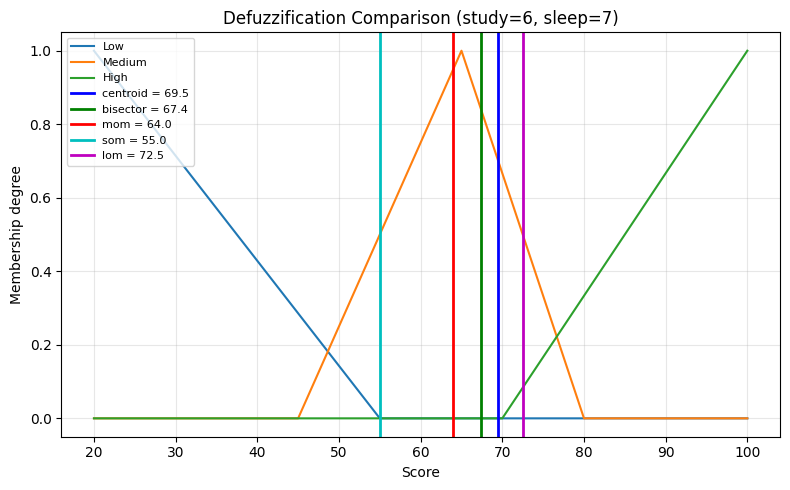

Comparison plot saved as 'defuzzification_comparison.png'


In [27]:
# ==========================================================
# 9. Comparison of Different Defuzzification Techniques
# ==========================================================
import matplotlib.pyplot as plt

print("\n Generating comparison of defuzzification methods...")

methods = ['centroid', 'bisector', 'mom', 'som', 'lom']
colors = ['b', 'g', 'r', 'c', 'm']

# Prepare base fuzzy output curve for plotting
x_score = np.arange(20, 101, 1)
score_low = fuzz.trimf(x_score, [20, 20, 55])
score_medium = fuzz.trimf(x_score, [45, 65, 80])
score_high = fuzz.trimf(x_score, [70, 100, 100])

# Set input for testing (example: a good student)
study_val = 6
sleep_val = 7

plt.figure(figsize=(8, 5))

# Draw base membership functions
plt.plot(x_score, score_low, label='Low')
plt.plot(x_score, score_medium, label='Medium')
plt.plot(x_score, score_high, label='High')

# For each method, compute and plot resulting crisp output
for method, color in zip(methods, colors):
    score.defuzzify_method = method
    sim_temp = ctrl.ControlSystemSimulation(ctrl_system)
    sim_temp.input['study'] = study_val
    sim_temp.input['sleep'] = sleep_val
    sim_temp.compute()

    if 'score' in sim_temp.output:
        crisp_value = sim_temp.output['score']
        plt.axvline(crisp_value, color=color, linewidth=2,
                    label=f'{method} = {crisp_value:.1f}')
    else:
        print(f" No output for method '{method}' (no active rules).")

plt.title(f"Defuzzification Comparison (study={study_val}, sleep={sleep_val})")
plt.xlabel("Score")
plt.ylabel("Membership degree")
plt.legend(loc='upper left', fontsize=8)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("defuzzification_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("Comparison plot saved as 'defuzzification_comparison.png'")


In [12]:
# -------------------------------
# 7. Test Simulation (Examples)
# -------------------------------
test_cases = [
    {'study': 2, 'sleep': 5},
    {'study': 5, 'sleep': 6},
    {'study': 7, 'sleep': 7},
    {'study': 3, 'sleep': 8}
]

for i, case in enumerate(test_cases, start=1):
    sim.input['study'] = case['study']
    sim.input['sleep'] = case['sleep']
    sim.compute()
    print(f"Case {i}: study={case['study']} h, sleep={case['sleep']} h → predicted score = {sim.output['score']:.2f}")

# -------------------------------

Case 1: study=2 h, sleep=5 h → predicted score = 34.78
Case 2: study=5 h, sleep=6 h → predicted score = 63.25
Case 3: study=7 h, sleep=7 h → predicted score = 74.68
Case 4: study=3 h, sleep=8 h → predicted score = 62.80



🪄 Generating 3D control surface...


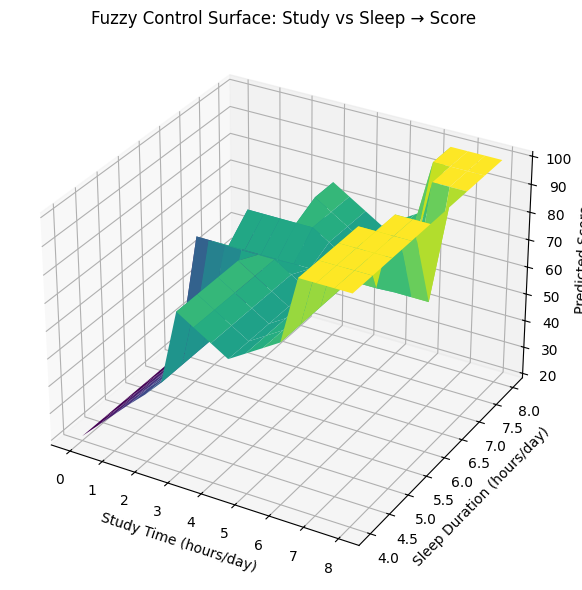

 Control surface generated and saved as fuzzy_control_surface.png


In [25]:
# ---------------------------------------------
# 8. Generate and Save 3D Output Surface Plot (Safe Version)
# ---------------------------------------------
print("\n🪄 Generating 3D control surface...")

study_vals = np.arange(0, 8.5, 0.5)
sleep_vals = np.arange(4, 8.5, 0.5)
x, y = np.meshgrid(study_vals, sleep_vals)
z = np.zeros_like(x, dtype=float)

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        sim_local = ctrl.ControlSystemSimulation(ctrl_system)
        sim_local.input['study'] = x[i, j]
        sim_local.input['sleep'] = y[i, j]
        sim_local.compute()

        #  check if output exists before assigning
        if 'score' in sim_local.output:
            z[i, j] = sim_local.output['score']
        else:
            z[i, j] = np.nan  # or 0, depending on your preference

# Plot and save 3D surface
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(x, y, z, cmap='viridis', linewidth=0.3, antialiased=True)
ax.set_xlabel('Study Time (hours/day)')
ax.set_ylabel('Sleep Duration (hours/day)')
ax.set_zlabel('Predicted Score')
ax.set_title('Fuzzy Control Surface: Study vs Sleep → Score')
plt.tight_layout()
#plt.savefig("fuzzy_control_surface.png", dpi=150, bbox_inches="tight")
#plt.close()
plt.show()

print(" Control surface generated and saved as fuzzy_control_surface.png")
